# Hands-On Activity: Inverse Modeling of Cervical Tissue

by [Camilo A. Duarte-Cordon](https://scholar.google.com/citations?user=d1GtGzgAAAAJ&hl=en&oi=ao), Postdoctoral Researcher in [Myer's Soft Tissue Lab](https://kristinmyerscolumbia.com/) version 2.0\
Last updated 3/242024

---

## Objective

The objective of this example is to demonstrate how different methods of optimization, gradient-based and gradient-free, perform in an inverse modeling problem of material model calibration.

---

## 0. Load Python libraries

Install bayesian optimization package:

In [1]:
#pip install bayesian-optimization

Mount data from drive:

In [ ]:
# Mount data from drive
#from google.colab import drive
#drive.mount("/content/drive/", force_remount=True)

Move to directory:

In [131]:
#cd drive/MyDrive/biomech_IFEA_lecture

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.special import gamma, factorial, beta, betainc
from bayes_opt import BayesianOptimization # library for optimization
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150
import seaborn as sns
import scipy.optimize
sns.set_style('white')
sns.set_context('talk')

## 1. Load spherical indentation data

First, we want to load the experimental data we will use for inverse modeling. In this case, we will use data from a spherical indentation test. The file 'Specimen_RawData_1.csv' contains the experimental data, which consists of three columns: time in [s], displacement of the indenter in [mm], and the indenter force in [N]. The following script loads and cleans the data for our use:

In [3]:
# load data, skip the first 4 rows
exp_data = pd.read_csv('Specimen_RawData_1.csv', 
                       delimiter = ",", 
                       skiprows = [0,1,2,3], 
                       usecols = [0,1,2], 
                       names= ['t','uz','fz'])
# delete comma in thousands separator
exp_data['t'] = exp_data['t'].str.replace(',','')
# convert data to numeric type
exp_data = exp_data.apply(pd.to_numeric,errors = 'coerce')
# drop rows with NaN values 
exp_data = exp_data.dropna(subset=['t'])
# reset index 
exp_data = exp_data.dropna().reset_index(drop=True)
# substract first row to all values
first_row = exp_data.iloc[[0]].values[0]
exp_data = exp_data.apply(lambda row: row - first_row, axis=1)
exp_data.head()

,t,uz,fz
0,0.0,0.00000,0.00000
1,0.1,-0.00182,-0.00016
2,0.2,-0.00578,-0.00013
3,0.3,-0.00944,0.00005
4,0.4,-0.01300,-0.00010


Let's plot the experimental results:

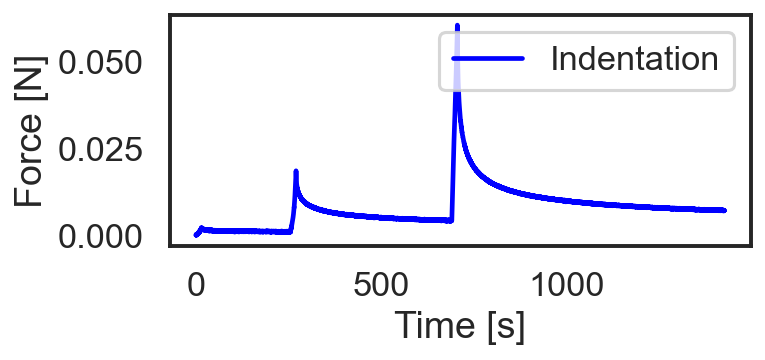

In [4]:
fig, ax = plt.subplots(figsize=(5, 2))
ax.plot(exp_data.t, abs(exp_data.fz),'-b', label='Indentation')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.legend();

## 2. Constitutive model

We aim to maximize the agreement between experimental and theoretical data in inverse modeling. We picked a material model or constitutive equation to obtain the material parameters that could match our experimental results. We could use different phenomenological viscoelastic models, such as Maxwell, Kelvin-Voigh, or the Generalized Maxwell model, reactive viscoelasticity, etc. The models can follow different formulations: linear, quasi-linear, and nonlinear, depending on whether the relaxation function $G(t)$ depends on the strain $\varepsilon$.

For this example, we picked the spring pot viscoelastic model, which consists of spring in parallel with a fractional-order dashpot element. This linear viscoelastic model can be expressed in terms od the Boltzmann integral:

$$\sigma(t)=\int_{0}^{t} G(t - \tau) \frac{\mathrm{d} \mathrm{\varepsilon (t) } }{\mathrm{d} \tau} \mathrm{d} \tau$$

![title](Springpot.png)

For the springpot the relaxation function is given by:

$$ G(t)= E_0 + \eta \frac{t^{-\alpha}}{\Gamma(1-\alpha)} = E_0\left [ 1 + \frac{(t/\tau)^{-\alpha}}{\Gamma(1-\alpha)} \right ] $$

Fortunately for us, there is an analytical solution for the force for the case of ramp-hold force:

$$ h(t)= \{ \begin{matrix} v_0\cdot t & 0 \leq t < T_r\\ v_0 \cdot T_r &  t \geq T_r
\end{matrix} $$

The force is given by:

$$P(t)=K_G \int_{0}^{t} G(t - u) \frac{\mathrm{d} h^n}{\mathrm{d} u} \mathrm{d} u$$

For spherical indentation  $n = 3/2$, $K_G = 8 \sqrt{R}/3$, $\alpha$ > 0. For this experiment, we have the following parameters:

In [5]:
T_r = 15 # s
R = 2.5 # mm
v = 0.04 # mm/s

The analytical solution of the force can be obtained from the following function

In [6]:
def Springpot(t,E_0,alpha,tau):
    """Relaxation force sprinpot viscoelastic model.
    
    Arguments
    t     -- The time in (s)
    E_0   -- Spring stifness (MPa)
    alpha -- Power exponent
    tau   -- Relaxation time in (s)
    
    Other constants
    T_r   -- Rising time
    R     -- Radius spherical indentor in (mm)
    v     -- ramp rate in mm/s
    """
    if t <= T_r:
        return 4 *  R ** (1/2) * v ** (3/2) * E_0 * t ** (3/2) * (2/3 + (t/tau) ** (-1 * alpha)/gamma(1 - alpha ) * beta( 3/2 ,1 - alpha) )
    else:
        return 4 *  R ** (1/2) * v ** (3/2) * E_0 * T_r ** (3/2) * (2/3 + (t / T_r) ** (3/2) *  (t / tau ) ** (-1 * alpha) / gamma(1 - alpha) * betainc( 3/2 , 1 - alpha, T_r/t) * gamma (3/2) * gamma (1-alpha) / gamma (3/2 + 1 - alpha) )

## 3. Inverse problem

Suppose you have a constitutive material model that predicts a quantity of interest (e.g., force/stress over time). Let's assume this model has scalar parameters you do not know, denoted by the vector $\textbf{x}$. Let's say we perform an experiment that measures a *noisy* vector $\textbf{y}$. Assume that you can use your constitutive model $f(\textbf{x})$ to predict $\textbf{y}$. $\mathbf{f}(\mathbf{x})$ may be a costly simulation or an analytical expression. The **inverse problem**, otherwise known as the **model calibration** problem is to find the ``best`` $\textbf{x}$ so that:
$$
f(\textbf{x}) \approx \textbf{y}.
$$ 

What does it really mean for $f(\textbf{x})$ to be close to $\textbf{y}$? Let us introduce a *loss function* $\ell(f(\textbf{x}),\textbf{y})$ which tells how much our prediction is off if we chose the input $\textbf{x }$. We can formulate the mathematical problem as:
$$
\min_{x\in\mathcal{X}} \ell(f(\textbf{x}),\textbf{y}).
$$

The choice of the loss function is subjective (it depends on what it means to be wrong in your problem).  A very common choice is the *square loss*:
$$
\ell(f(x), y) = \frac{1}{2}\parallel f(\textbf{x}) - \textbf{y}\parallel_2^2 = \frac{1}{2}\sum_{i=1}^m\left(f_i(x)-y_i\right)^2.
$$

Let's define the loss function in python:

In [7]:
# The function that predicts y
def f(x, t):
    """Function that defines constitutive model.
    
    Arguments
    x     -- array [x_0, x_1, x_3] 
    t     -- arrray with training data for time
    """    
    return np.array([Springpot(i,x[0],x[1],x[2]) for i in t])

# The loss function that we need to minimize over x
def L(x, t, y):
    """Loss function.
    
    Arguments
    x     -- array [x_0, x_1, x_3] 
    t     -- arrray with training data of time
    y     -- arrray with training data of force
    """    
    return 0.5 * np.sum((f(x,t) - y) ** 2) # 

Data used for training:

In [8]:
# Let's define the loss function
t_train = np.array(exp_data.t[152:2550])
y_train = abs(np.array(exp_data.fz[152:2550]))

### a. Gradient-based method:

Let's optimize:

In [87]:
from scipy.optimize import Bounds

# Define the bounds for optimization
bounds = [(1e-5,1e-3), (1e-6,0.99), (0.01,100)]

# Define initial guess for x
x0 = np.array([1e-4, 0.2, 1.0])


# Optimization with Sequential Least Squares Programming 
opt_grad = scipy.optimize.minimize(L,x0,args=(t_train,y_train), 
                              bounds=bounds, options={'ftol': 1e-6, 'disp': True})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.54286D-04    |proj g|=  9.00000D-04

At iterate    1    f=  1.97743D-05    |proj g|=  5.66467D-04

At iterate    2    f=  1.97740D-05    |proj g|=  2.36750D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      3     0     0   2.367D-05   1.977D-05
  F =   1.9774041146024939E-005

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


Results:

In [88]:
print('E_0 = '   + str(opt_grad.x[0]) + ' MPa')
print('alpha = ' + str(opt_grad.x[1]))
print('tau = '   + str(opt_grad.x[2]) + ' s')

E_0 = 0.00043368893838954104 MPa
alpha = 0.19971322405417685
tau = 1.000010962181725 s


Let's plot the results:

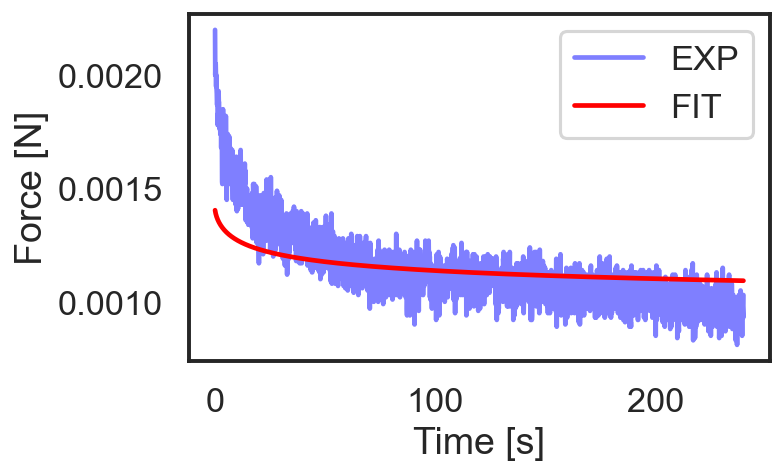

In [77]:
fig, ax = plt.subplots(figsize=(5, 3))
y_grad = f([opt_grad.x[0],opt_grad.x[1],opt_grad.x[2]],t_train)
ax.plot(t_train-T_r, abs(y_train),'-b', label='EXP', alpha = 0.5)
ax.plot(t_train-T_r, y_grad,'-r', label='FIT')
plt.xlabel('Time [s]')
plt.ylabel(r'Force [N]')
plt.legend();

### b. Non-gradient-based method:

In [118]:
# Let's define the loss function
def loss(E_0,alpha,tau):
    """Loss function
    
    Arguments
    E_0   -- Spring stifness (MPa)
    alpha -- Power exponent
    tau   -- Relaxation time in (s)

    
    Other constants
    T_r   -- Rising time
    R     -- Radius spherical indentor in (mm)
    v     -- ramp rate in mm/s
    
    t_train     -- Experiment data time in (s)
    y_train     -- Experimental data force in (N)
    
    """
    f = np.array([Springpot(t,E_0,alpha,tau) for t in t_train])
    tmp = (abs(f) - abs(y_train))
    L = -0.5 * np.sum(tmp ** 2) # make negative to maximize
    return L

In [119]:
pbounds = {'E_0': (1e-5,1e-3), 'alpha':(1e-6,0.99), 'tau':(0.01,100)}

opt_bayes = BayesianOptimization(
    f = loss,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

In [125]:
opt_bayes.maximize(
    init_points=3,
    n_iter=100,
)

|   iter    |  target   |    E_0    |   alpha   |    tau    |
-------------------------------------------------------------
| 54        | -0.000408 | 0.0005434 | 0.415     | 68.53     |
| 55        | -0.000658 | 0.0002124 | 0.8693    | 2.748     |
| 56        | -0.001038 | 0.0006738 | 0.4131    | 55.87     |
| 57        | -7.674e-0 | 0.0004606 | 0.5035    | 24.26     |
| 58        | -0.001203 | 5.178e-05 | 0.6511    | 99.12     |
| 59        | -0.000955 | 6.81e-05  | 0.01347   | 86.63     |
| 60        | -0.000873 | 0.0001176 | 0.8073    | 97.46     |
| 61        | -0.004224 | 0.000873  | 0.1768    | 41.88     |
| 62        | -0.000889 | 8.119e-05 | 0.1545    | 67.75     |
| 63        | -0.0011   | 0.0006312 | 0.289     | 58.39     |
| 64        | -0.000675 | 0.0005719 | 0.2726    | 51.25     |
| 65        | -0.002685 | 0.000953  | 0.2461    | 5.472     |
| 66        | -0.000280 | 0.0002647 | 0.7341    | 66.11     |
| 67        | -0.001376 | 2.684e-05 | 0.2904    | 31.17     |
| 68    

| 135       | -0.000239 | 0.0002078 | 0.297     | 73.99     |
| 136       | -0.001349 | 3.054e-05 | 0.5444    | 84.68     |
| 137       | -0.000107 | 0.0004128 | 0.7267    | 10.46     |
| 138       | -7.766e-0 | 0.0002475 | 0.01778   | 20.13     |
| 139       | -0.000145 | 0.0002716 | 0.4882    | 60.9      |
| 140       | -0.000411 | 0.0006731 | 0.6632    | 48.91     |
| 141       | -6.183e-0 | 0.0004154 | 0.8389    | 53.44     |
| 142       | -0.001133 | 9.297e-05 | 0.909     | 7.087     |
| 143       | -0.000878 | 0.0005338 | 0.1401    | 92.92     |
| 144       | -0.001726 | 0.000797  | 0.5189    | 61.76     |
| 145       | -0.000123 | 0.0005878 | 0.5327    | 21.09     |
| 146       | -0.000712 | 0.0006831 | 0.4404    | 33.16     |
| 147       | -0.001377 | 4.021e-05 | 0.748     | 8.198     |
| 148       | -0.000927 | 0.0009966 | 0.9459    | 33.2      |
| 149       | -0.001236 | 6.192e-05 | 0.7798    | 33.83     |
| 150       | -0.000174 | 0.0002216 | 0.1437    | 43.13     |
| 151   

Plot the loss function value with the number of iterations:

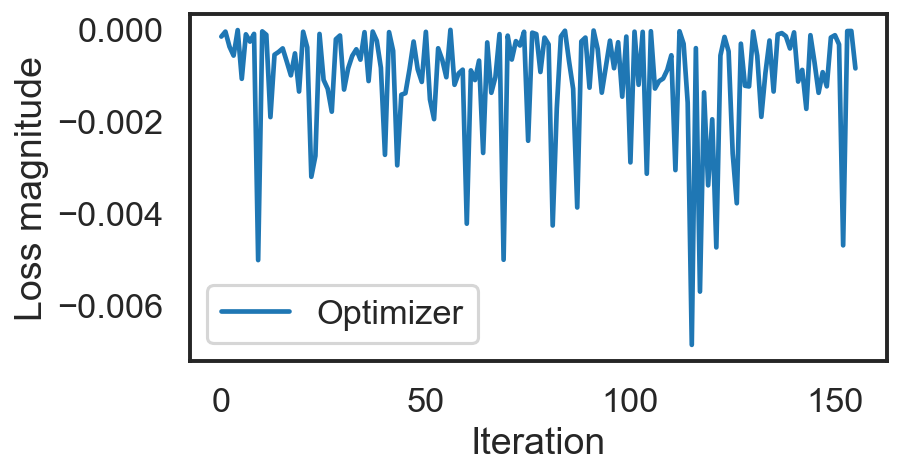

In [126]:
fig, ax = plt.subplots(figsize=(6, 3))
plt.plot(opt_bayes.space.target, label='Optimizer')
plt.xlabel('Iteration')
plt.ylabel(r'Loss magnitude')
plt.legend();

In [127]:
print('E_0 = '   + str(opt_bayes.max['params']['E_0']) + ' MPa')
print('alpha = ' + str(opt_bayes.max['params']['alpha']))
print('tau = '   + str(opt_bayes.max['params']['tau']) + ' s')

E_0 = 0.0004606459628256584 MPa
alpha = 0.50347642554577
tau = 24.263110270888607 s


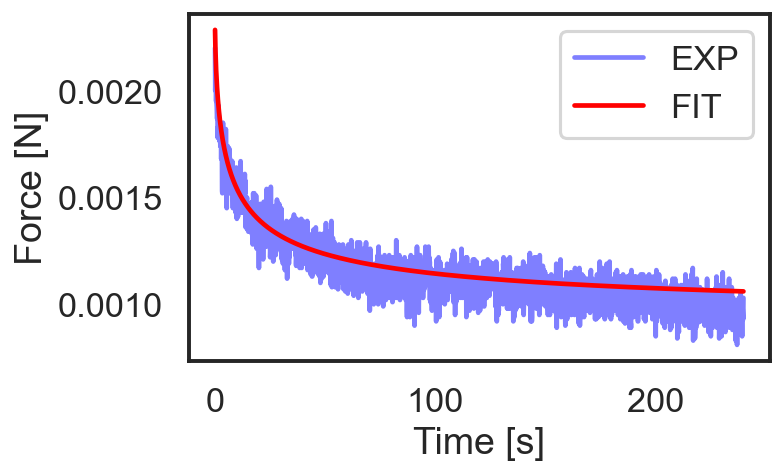

In [128]:
fig, ax = plt.subplots(figsize=(5, 3))
y_bayes = np.array([Springpot(t,opt_bayes.max['params']['E_0'],opt_bayes.max['params']['alpha'],opt_bayes.max['params']['tau']) for t in t_train]) 
ax.plot(t_train-T_r, abs(y_train),'-b', label='EXP', alpha = 0.5)
ax.plot(t_train-T_r, y_bayes,'-r', label='FIT')
plt.xlabel('Time [s]')
plt.ylabel(r'Force [N]')
plt.legend();

## 4. Metrics

The mean squared error (MSE) is a scalar measure of the goodness of fit. The MSE is the mean of the sum of the square of the prediction error over your test data. The formula gives the MSE of your model:

$$
MSE = \frac{\sum_{i = 1}^{N} (y_i - f_i(\textbf{x}))^2}{N}
$$

Smaller MSE means better model fit. However it is still had to understand the absolute meaning of he MSS. We could use the  relative RMSE valueL

$$
RMSE = \frac{\sum_{i = 1}^{N} (y_i - f_i(\textbf{x}))^2}{\sum_{i = 1}^{N} (y_i - \hat{\mu})^2}
$$

where:

$$
\hat{\mu} = \frac{1}{N}\sum_{i = 1}^{N}y_i
$$

Cotefficient of determination, how much of the percentage of the vaiances is explanied by your model.

$$
R^2 = 1 - RMSE = 1 -  \frac{\sum_{i = 1}^{N} (y_i - f_i(\textbf{x}))^2}{\sum_{i = 1}^{N} (y_i - \hat{\mu})^2}
$$

In [129]:
mu = y_train.mean()
MSE_grad = np.mean((y_train - y_grad)** 2)
print('MSE = {0:1.2e}'.format(MSE_grad))
MSE_sim_grad = np.mean((y_train - mu) ** 2) 
RMSE_grad = MSE_grad / MSE_sim_grad 
print('RMSE = {0:1.2e}'.format(RMSE_grad))
R2_grad  = 1 - RMSE_grad
print('R2 = {0:1.6f}'.format(R2_grad))

MSE = 1.65e-08
RMSE = 5.29e-01
R2 = 0.470938


So, in this example our model explains about 47% of the variance of the train data.

In [130]:
mu = y_train.mean()
MSE_bayes = np.mean((y_train - y_bayes)** 2)
print('MSE = {0:1.2e}'.format(MSE_bayes))
MSE_sim_bayes = np.mean((y_train - mu) ** 2) 
RMSE_bayes = MSE_bayes / MSE_sim_bayes
print('RMSE = {0:1.2e}'.format(RMSE_bayes))
R2_bayes  = 1 - RMSE_bayes
print('R2 = {0:1.6f}'.format(R2_bayes))

MSE = 6.40e-09
RMSE = 2.05e-01
R2 = 0.794670


In this example our model explains about 79% of the variance of the train data.

## Questions

+ Modify the initial guess in the gradient-based method.
+ Modify the number of iteration in the bayesian method.